In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

## <center>Problem 1: Predicting DNA Binding Sites</center>

In [ ]:
# Download data 
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/train_dna.csv

--2022-03-14 19:33:07--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/train_dna.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1408340 (1.3M) [text/plain]
Saving to: ‘train_dna.csv’

train_dna.csv       100%[===================>]   1.34M  --.-KB/s    in 0.05s   

2022-03-14 19:33:08 (25.4 MB/s) - ‘train_dna.csv’ saved [1408340/1408340]



In [ ]:
train_pd = pd.read_csv("./train_dna.csv")

X = train_pd.seq.values
y = train_pd.bind.values

### 1.1 (15 points) Build Datasets and DataLoaders in PyTorch

One-hot encode DNA sequence data.

In [ ]:
def SeqEnc(sequences):
    # Write your one-hot encoding code here
    encoding = {'A': [1,0,0,0],
                'T': [0,1,0,0],
                'G': [0,0,1,0],
                'C': [0,0,0,1]}
    # sequences - an array of DNA sequences as strings
    encoded = []
    for seq in sequences:
      encoded_seq = []
      for base in seq:
        encoded_seq.append(encoding[base])
      encoded.append(encoded_seq)
    return np.asarray(encoded)
    
X = SeqEnc(X)
X

array([[[0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        ...,
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 0, 0]],

       ...,

       [[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0]],

       [[0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]])

Implement your dataset class that takes in your data.

In [ ]:
# Generate dataset 
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.y = torch.Tensor(y)  # store y as a pytorch Tensor
        self.len=len(self.X)      # number of samples in the data 

    def __getitem__(self, index):
        # your implementation here: 
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len
    

Define your Datasets and DataLoaders.

In [ ]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
#Build Dataset 
train_data = SequenceDataset(X_train, y_train)
val_data = SequenceDataset(X_val, y_val)
test_data = SequenceDataset(X_test, y_test)

# Build DataLoader 
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

What is the benefit of batching your data into mini-batches versus using the entire dataset to optimize the model all at once?

In [ ]:
'''
Mini-batches add sufficient noise within each gradient update to allow for non-convex optimization, avoiding convergence to local minima and saddle points. 
This also allows for better generalization. Additionally, mini-batches enable faster convergence towards the minimum because you do not compute
the gradient over the entire dataset.
'''

### 1.2 (20 points) Build an LSTM-based binding classifier 

The following example will help familiarize you with the LSTM.

In [ ]:
# Define a LSTM module 
lstm_model = nn.LSTM(input_size=4, hidden_size=16, batch_first=True, bidirectional=True).to("cuda:0") # "cuda:0" is the device id

# Send your batch to a GPU 
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.to("cuda:0")
y_batch = y_batch.to("cuda:0")

# Propagate your batch into your model 
lstm_out, (ht, ct) = lstm_model(X_batch) 
print(lstm_out.shape, ht.shape, ct.shape)

# You can play with hyperparameters to see how your output changes

torch.Size([256, 101, 32]) torch.Size([2, 256, 16]) torch.Size([2, 256, 16])


Now build your LSTM-based classifier as a nn.Module.

In [ ]:
class LSTMseq(torch.nn.Module) :
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        
        # Define a LSTM module
        self.lstm = nn.LSTM(batch_first=True, num_layers=1, bidirectional=True, input_size=input_dim, hidden_size=hidden_dim).to("cuda:0") # "cuda:0" is the device id
        # Define a MLP regressor 
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, 1)
        )
        # Define a sigmoid transform
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        
        # Apply LSTM 
        lstm_out, (ht, ct) = self.lstm(x) 
        # Pass output into a MLP 
        mlp_out = self.mlp(ht[1])
        # Transform output into probabilites 
        proba = self.sigmoid(mlp_out)
        # Return probabilities 
        return proba

In [ ]:
# Test your output on a batch 
clf = LSTMseq(input_dim=4, hidden_dim=16).to('cuda:0')
print(clf(X_batch).shape)

torch.Size([256, 1])


### 1.3 (25 points) Implement functions for training and testing

Your optimizer and scheduler.

In [ ]:
device = 'cuda:0'
model = LSTMseq(4, 16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.5)

The training and validation loops and evaluation function.

In [ ]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        label = torch.unsqueeze(label, dim=1)
        
        # train your model on each batch here         
        loss = torch.nn.functional.binary_cross_entropy(model(seq), label)   # fill in loss here
        batch_loss.append(loss.item())

        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(batch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            label = torch.unsqueeze(label, dim=1)
            
            # validate your model on each batch here
            loss = torch.nn.functional.binary_cross_entropy(model(seq), label)   # fill in loss here
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean() 

def evaluate(model, dataloader, device):

    '''
    A function to return the classification probabilities and true labels (for evaluation). 
    
    Args: 
        model (torch.nn.Module): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        device (str): Your device
        
    Returns: 
        (np.array, np.array): true labels, predicted probabilities
    '''

    pred_prob = []
    labels = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            
            # evaluate your model here 
            pred = torch.squeeze(model(seq), dim=1)
            pred_prob.append(pred)
            labels.append(label)
            
    return labels, pred_prob

In [ ]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(500):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer,  device=0)
    
    # Validate your on validation data 
    val_loss = validate(model, val_loader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    scheduler.step(val_loss)
    
    print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 0.6943956452447015 0.6932015419006348
1 0.6930828448888418 0.6915639162063598
2 0.6932365990973808 0.6925422549247742
3 0.6912662564097224 0.6933345079421998
4 0.6912368906510843 0.6941992521286011
5 0.6910426294481432 0.7112929582595825
6 0.6909753019745285 0.6990575790405273
7 0.692639946937561 0.6921503424644471
8 0.6920172201620566 0.6913762927055359
9 0.6888560958810754 0.6932968258857727
10 0.6849356986380912 0.6858105182647705
11 0.691415730360392 0.6879594922065735
12 0.6871631596539471 0.6892371535301208
13 0.6760852659070814 0.6832379221916198
14 0.631675441522856 0.5943018317222595
15 0.5736310812267097 0.5789772391319274
16 0.5589726647815189 0.5612598776817321
17 0.5278082353037756 0.48385847806930543
18 0.5096371737686364 0.46148603558540346
19 0.48142364862802867 0.47919132113456725
20 0.464094835358697 0.38671611845493314
21 0.3876587877402434 0.34123014807701113
22 0.37173077262736653 0.3799516141414642
23 0.3263809854114378 0.3268630

Plot train and validation loss functions.

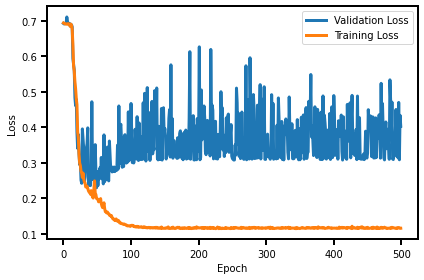

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(val_loss_curve, label='Validation Loss')
ax.plot(train_loss_curve, label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
fig.tight_layout()

Report the AUC on test data.

In [ ]:
# Code to compute AUC on test data 
model.eval()
labels, pred_prob = evaluate(model, test_loader, device=0)

labels = labels[0].detach().cpu().numpy()   # convert tensor to numpy
pred_prob = pred_prob[0].detach().cpu().numpy()   # convert tensor to numpy

test_score = roc_auc_score(labels, pred_prob)
    
print("AUC on the test dataset is {}.".format(test_score) ) 

AUC on the test dataset is 0.9585545992797412.


## Part 2: Dimensionality Reduction for Molecular Representations

In [ ]:
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/drug.csv
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/morgan.csv

--2022-03-15 20:36:24--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/drug.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314383 (307K) [text/plain]
Saving to: ‘drug.csv.1’

drug.csv.1          100%[===================>] 307.01K  --.-KB/s    in 0.03s   

2022-03-15 20:36:24 (9.51 MB/s) - ‘drug.csv.1’ saved [314383/314383]

--2022-03-15 20:36:24--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps3/data/morgan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 

In [ ]:
# load data 
df = pd.read_csv("drug.csv")
fp = np.loadtxt('morgan.csv', delimiter=',')

assert fp.shape[0] == df.shape[0]

### 2.1 (10 points) Principal Component Analysis on Molecular Fingerprints

Perform PCA to reduce data into vectors of 100 dimensions.

79 4550
(4629, 512) (4629, 100)


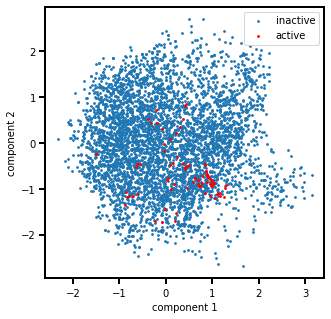

In [ ]:
active_indices = df.index[df['is_active']==1].tolist()
inactive_indices = df.index[df['is_active']==0].tolist()
print(len(active_indices), len(inactive_indices))

pca = PCA(n_components=100)
projected = pca.fit_transform(fp)
print(fp.shape, projected.shape)


# skeleton code for plotting

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(projected[inactive_indices, 0], projected[inactive_indices, 1], s=3, label='inactive') 
ax.scatter(projected[active_indices, 0], projected[active_indices, 1], color='red', s= 3, label='active')
plt.xlabel('component 1')
plt.ylabel('component 2')
ax.legend()

What is the explained variance ratio of the 100 principal components?

In [ ]:
print("The first 100 components explains {} of the total variance".format(sum(pca.explained_variance_ratio_)) )

The first 100 components explains 0.6230736883105903 of the total variance


What patterns do you observe?

In [ ]:
'''
There are not defined very patterns, but there is a clustering of red datapoints (active) around
(component1, component2)=(1,-1), mostly ranging between -1 and 1 for both components. Additionally,
both components for the blue datapoints (inactive) are mostly centered between -2 and 2.
'''

### 2.2 (10 points) t-SNE analysis on Molecular Fingerprints

Perform t-SNE on the obtained principal components, with perplexity value of 2, 30, and 500. Plot the results and label your plots.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(4629, 2)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(4629, 2)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(4629, 2)


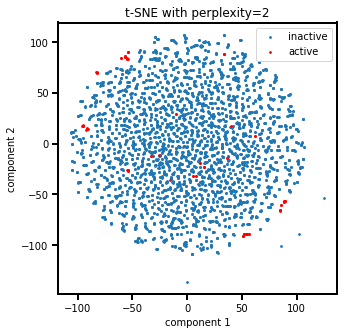

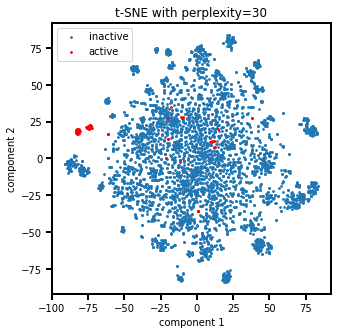

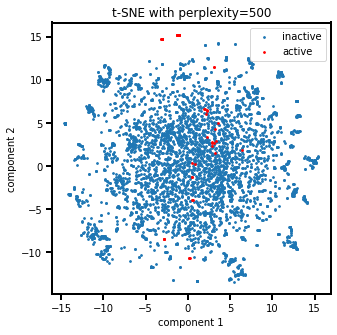

In [ ]:
perplexity_vals = [2, 30, 500]

for perplexity in perplexity_vals:
  tsne_projected = TSNE(n_components=2, perplexity=perplexity).fit_transform(projected)
  print(tsne_projected.shape)

  # skeleton code for plotting
  fig, ax = plt.subplots(figsize=(5,5))
  ax.scatter(tsne_projected[inactive_indices, 0], tsne_projected[inactive_indices, 1], s=3, label='inactive') 
  ax.scatter(tsne_projected[active_indices, 0], tsne_projected[active_indices, 1], color='red', s= 3, label='active')
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.title(f"t-SNE with perplexity={perplexity}")
  ax.legend()


What differences do you see between the 3 t-SNE plots? What patterns do you observe in the perplexity = 30 plot?

In [ ]:
'''
When we have a perplexity of 2, the datapoints are relatively dispersed and
local variations seem to dominate with the less defined clustering. When we
increase the perplexity value to 30, we see more defined shapes and clusterings.
However, once we increase it to 100, the shapes become less defined again,
but still more defined than when perplexity=2.
'''

### 2.3 (15 points) Are the low dimensional embeddings meaningful?

Split the data into 10 folds. For each fold, train on the other 9 folds and validate on the last fold. Record your prediction.

In [ ]:
kf = KFold(n_splits=10, shuffle=True)
is_active = np.array(df["is_active"])

y_pred = []
y_true = []
indices = []   # keep track of the indices after Kfold splits and shuffles
for train_index, test_index in kf.split(fp):
  X_train, X_test = fp[train_index], fp[test_index]
  y_train, y_test = is_active[train_index], is_active[test_index]

  clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
  y_pred.extend(clf.predict(X_test))
  y_true.extend(y_test)
  indices.extend(test_index)

Classify your predictions into True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN).

In [ ]:
TP = []
TN = []
FP = []
FN = []

for i in range(len(y_pred)):
  # real prediction: inactive 
  if y_true[i]==0:
    if y_pred[i]==0:
      TN.append(indices[i])
    elif y_pred[i]==1:
      FP.append(indices[i])
  # real prediction: active
  elif y_true[i]==1:
    if y_pred[i]==0:
      FN.append(indices[i])
    elif y_pred[i]==1:
      TP.append(indices[i])

len(TN), len(FN), len(TP), len(FP)

(4550, 26, 53, 0)

Plot the 2D t-SNE embeddings (perplexity = 30) colored by the four classification classes.

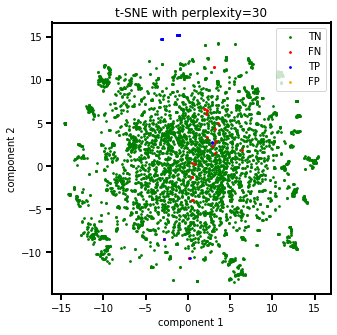

In [ ]:
color = {'TN': 'green', 'FN': 'red', 'TP': 'blue', 'FP': 'orange'}
categ_indices = {'TN': TN, 'FN': FN, 'TP': TP, 'FP': FP}

# skeleton code for plotting
fig, ax = plt.subplots(figsize=(5,5))

for category in color:
  ax.scatter(tsne_projected[categ_indices[category], 0], tsne_projected[categ_indices[category], 1], s=3, color=color[category],label=category) 

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title("t-SNE with perplexity=30")
ax.legend()


What pattern do you observe? 

In [ ]:
'''
The majority of our datapoints were TN while none were FP. This could potentially be due to
our skew in the dataset (ie. most were inactive, compared to active). TP were mostly clustered
at low component 1 values (between -5 and 0), but fairly large component 2 values (around 15).
Additionally, FN normally occurred when component 1 was approximately 0, whereas there was a range
for component 2 values (ranging from -5 to 10). There was some clustering on the periphery for TN
and the first and second component values ranged from -15 to 15.
'''